In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

### Create a true underlying function

In [2]:
def f_true(x):
    return (x ** 2 * np.sin(x) + 3) / 5

def oracle(x):
    return f_true(x) + np.random.normal(0, 1, size=len(x))

def sample(n):
    xs = np.random.random_sample(n) * 20 - 10
    return xs, oracle(xs)

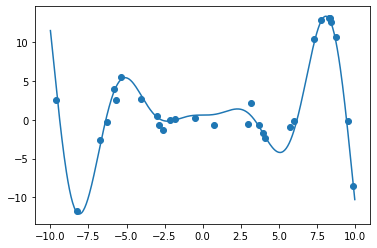

In [3]:
xs_all = np.linspace(-10, 10, 400)
ys_all = [f_true(x) for x in xs_all]
plt.plot(xs_all, ys_all)

xs, ys = sample(30)
plt.scatter(xs, ys)

### Augment X

In [4]:
def Phi_factory(xs, basis_funcs):
    return np.array([[f(x) for f in basis_funcs] for x in xs])

In [5]:
def poly_basis(degree):
    return [lambda x, d=d: x ** d for d in range(degree + 1)]

In [6]:
def rbf_basis(centers, sigma_sqr):
    return [lambda x, c=c: np.exp(-(x - c) ** 2 / (2 * sigma_sqr)) for c in centers]

Gaussian:
$$f(x) = \frac{1}{\sigma\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{\!2}\,\right)$$

Linear function:
$$f = \phi(x)^Tw + \epsilon\qquad \epsilon\sim\mathcal{N}(0, 1)$$

### MLE

Gaussian likelihood: $p(y\mid w, X) = \prod_N \mathcal{N}(y; \phi(x_n)^Tw, \sigma^2)$

$$
\begin{align*}
\bar{w} &= {\arg\max}_w \prod_N \mathcal{N}(y; \phi(x_n)^Tw, \sigma^2)\\
&= {\arg\min}_w \sum_N (y - \phi(x_n)^Tw)^2
\end{align*}
$$

$$
\begin{align*}
\frac{d}{dw} \sum_N (y - \phi(x_n)^Tw)^2 &= 0\\
\frac{d}{dw} ||\mathbf{y} - \Phi w||^2 &= 0\\
\Phi^T(\mathbf{y} - \Phi w) &= 0 \\
\Phi^T\mathbf{y} &= \Phi^T\Phi w\\
(\Phi^T\Phi)^{-1}\Phi^T\mathbf{y} &=  w
\end{align*}
$$

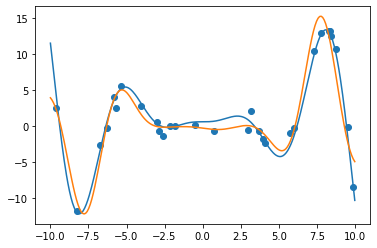

In [7]:
# funcs = poly_basis(4)
funcs = rbf_basis(np.linspace(-10, 10, 10), 1)
Phi = Phi_factory(xs, funcs)
w = np.linalg.inv(Phi.T.dot(Phi)).dot(Phi.T).dot(ys)
X_all = np.linspace(-10, 10, 200)
Phi_all = Phi_factory(X_all, funcs)
plt.scatter(xs, ys)
plt.plot(xs_all, ys_all)
plt.plot(X_all, Phi_all.dot(w))

### MAP

Equivalent to least square with l2 regularization if prior is gaussian with **zero mean**.

Gaussian prior: $p(w) = \mathcal{N}(w; 0, \sigma^2I)$

$$
\begin{align*}
\bar{w} &= \arg\max_w p(y \mid w, X)p(w) \\
&= {\arg\max}_w \prod_N \mathcal{N}(y; \phi(x_n)^Tw, \sigma^2_y) \prod_K \mathcal{N}(w_k; 0, \sigma_w^2)\\
&= {\arg\min}_w \frac{1}{2\sigma_y^2}\sum_N (y - \phi(x_n)^Tw)^2 + \frac{1}{2\sigma_w^2}\sum_K w_k^2\\
&= {\arg\min}_w \sum_N (y - \phi(x_n)^Tw)^2 + \frac{\sigma_y^2}{\sigma_w^2}\sum_K w_k^2\\
&= {\arg\min}_w \sum_N (y - \phi(x_n)^Tw)^2 + \lambda\sum_K w_k^2\qquad \lambda=\frac{\sigma_y^2}{\sigma_w^2}
\end{align*}
$$

$$
\begin{align*}
\frac{d}{dw} \sum_N (y - \phi(x_n)^Tw)^2 + \lambda\sum_K w_k^2 &= 0\\
\frac{d}{dw} ||\mathbf{y} - \Phi w||^2 + \lambda ||w||^2 &= 0\\
-\Phi^T(\mathbf{y} - \Phi w) + \lambda w &= 0 \\
\Phi^T\Phi w + \lambda w &= \Phi^T\mathbf{y}\\
(\Phi^T\Phi + \lambda I) w &= \Phi^T\mathbf{y}\\
w &= (\Phi^T\Phi + \lambda I)^{-1}\Phi^T\mathbf{y}\\
\end{align*}
$$

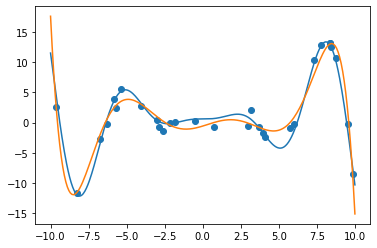

In [8]:
var_w = 1
funcs = poly_basis(7)
# funcs = rbf_basis(np.linspace(-10, 10, 30), 1)
Phi = Phi_factory(xs, funcs)
w = np.linalg.inv(Phi.T.dot(Phi) + np.diag([1/var_w] * Phi.shape[1])).dot(Phi.T).dot(ys)
X_all = np.linspace(-10, 10, 200)
Phi_all = Phi_factory(X_all, funcs)
plt.scatter(xs, ys)
plt.plot(xs_all, ys_all)
plt.plot(X_all, Phi_all.dot(w))

### Bayesian 

With gaussian prior and gaussion likelihood of the weights

$$\mathcal{N}(\mathbf {x};\mathbf{\mu}, \mathbf{\Sigma})={\frac {\exp \left(-{\frac {1}{2}}({\mathbf {x} }-{\boldsymbol {\mu }})^{\mathrm {T} }{\boldsymbol {\Sigma }}^{-1}({\mathbf {x} }-{\boldsymbol {\mu }})\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma }}|}}}$$



$$
\begin{align*}
\mathcal{N}(w; \mu_*, \Sigma_*) &\propto \mathcal{N}(y; \Phi w, \Sigma_y)\mathcal{N}(w; \mu_w, \Sigma_w)\\
&\propto -\frac{1}{2}(y - \Phi w)^T\Sigma_y^{-1}(y-\Phi w)-\frac{1}{2}(w - \mu_w)^T\Sigma_w^{-1}(w-\mu_w)\\
&\text{since posterior is in the weights, collect terms of $w$}\\
&\propto -\frac{1}{2}(\Phi w)^T\Sigma_y^{-1}\Phi w + y^T\Sigma_y^{-1}\Phi w-\frac{1}{2}w^T\Sigma_w^{-1}w + \mu_w^T\Sigma_w^{-1} w\\
&\propto -\frac{1}{2}w^T(\Phi^T\Sigma_y^{-1}\Phi + \Sigma_w^{-1})w + (y^T\Sigma_y^{-1}\Phi + \mu_w^T\Sigma_w^{-1}) w
\end{align*}
$$

$$
\begin{align*}
\Sigma_* &= (\Phi^T\Sigma_y^{-1}\Phi + \Sigma_w^{-1})^{-1}\\
\mu_*^T\Sigma_*^{-1} &= (y^T\Sigma_y^{-1}\Phi + \mu_w^T\Sigma_w^{-1})\\
\mu_*^T &= (y^T\Sigma_y^{-1}\Phi + \mu_w^T\Sigma_w^{-1})\Sigma_*\\
\end{align*}
$$

If $\Sigma_y = \sigma_y^2I$, $\Sigma_w = \sigma_w^2I$, and $\mu_w = 0$:
$$
\begin{align*}
\Sigma_* &= (\sigma_y^{-2}\Phi^T\Phi + \sigma_w^{-2})^{-1}\\
\mu_*^T &= \sigma_y^{-2}y^T\Phi\Sigma_*\\
\mu_* &= \sigma_y^{-2}\Sigma_*\Phi^T y
\end{align*}
$$
n.b. $\Sigma_*$ is symmetric.

This former update rules can be used to perform sequential updates (without any assumptions about variance and mean). 

The latter can be useful when we have observed all the data and want to update once, given an isotropic zero mean prior and known likelihood variance.

Predictive:
    
$$
p(y^*\mid \phi(x^*), y, X) = \int p(y^*\mid \phi(x^*), w) p(w\mid y, X) dw = \int \mathcal{N}(y^*; \phi(x^*)^Tw, \sigma^2_y) \mathcal{N}(w; \mu_*, \Sigma_*) dw
$$

Product of gaussians is a gaussian, and integral of a gaussian is a gaussian, the predictive has:

$$
\begin{align*}
\mu_\text{pred} &= \phi(x^*)^T\mu_*\\
\sigma^2_\text{pred} &= \phi(x^*)^T\Sigma_*\phi(x^*) + \sigma^2_y
\end{align*}
$$

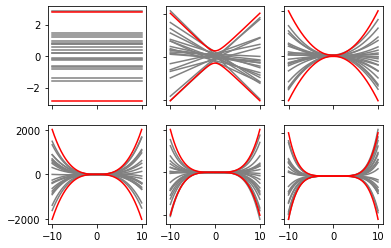

In [39]:
def sample(m, cov, size=1):
    return np.random.multivariate_normal(m, cov, size)


fig, axs = plt.subplots(2, 3)
for i in range(6):
    funcs = poly_basis(i)
#     funcs = rbf_basis(np.linspace(-10, 10, int(np.linspace(5,25,6)[i])), 1)
    Phi = Phi_factory(xs_all, funcs)
    for j in range(20):
        k = len(funcs)
        _ys = Phi.dot(sample(np.zeros(k), np.diag(np.ones(k)))[0])
        axs[i//3, i%3].plot(xs_all, _ys, c='grey')
    axs[i//3, i%3].plot(xs_all, 2 * np.sqrt((Phi ** 2).sum(axis=1) + 1), c='r')
    axs[i//3, i%3].plot(xs_all, -2 * np.sqrt((Phi ** 2).sum(axis=1) + 1), c='r')
for ax in axs.flat:
    ax.label_outer()